In [1]:
%matplotlib inline

import cv2
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

data_dir = 'us'

Steps: 
    1. preprocess image
    2. find possible characters in the scene
    3. find matching characters from the possible characters(meaning these chars are a group)
    4. find candidate plates from matching characters
    5. find characters in the plate
    6. recognize the chars in the plate
    7. compare the results and get the results and confidence value

In [2]:
image = cv2.imread(osp.join(data_dir, 'car1.jpg'))

In [3]:
debug = True

1. preprocess image

In [17]:
def maxContrast(gray_image):
    """
    construct tophat and blackhat images,
    then add with original image,
    return grayscale image + top hat - black hat
    """
    struct_elem = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    img_tophat = cv2.morphologyEx(gray_image, cv2.MORPH_TOPHAT, struct_elem)
    img_blackhat = cv2.morphologyEx(gray_image, cv2.MORPH_BLACKHAT, struct_elem)
    gray_tophat = cv2.add(gray_image, img_tophat)
    maxContrast_image = cv2.subtract(gray_tophat, img_blackhat)
    
    return maxContrast_image

def preprocess(image):
    ## 1.get the grayscale image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ## 2.get max_contrast_grayscale_image
    maxContrast_image = maxContrast(gray_image)
    ## 3.apply gaussian blur to remove noise
    blur_image = cv2.GaussianBlur(maxContrast_image, (5,5), 0)
    ## 4.change to binary image using adaptive threhold
    binary_image = cv2.adaptiveThreshold(blur_image, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY_INV, 19, 9)
    return gray_image, binary_image

2. find possible characters in the scene

In [18]:
class Character(object):
    def __init__(self, contour):
        """
        这里 x is column, y is row; 
        """
        self.contour = contour
        ## topleft (x,y), and (width, height)
        self.x, self.y, self.width, self.height = cv2.boundingRect(self.contour)
        
        self.area = self.width * self.height
        self.center_x = self.x + self.width / 2
        self.center_y = self.y + self.height / 2
        self.diag_size = np.sqrt(self.width**2 + self.height**2)
        self.aspect_ratio = self.width / self.height

In [19]:
MIN_PIXEL_AREA = 80
MIN_PIXEL_WIDTH = 2
MIN_PIXEL_HEIGHT = 8
MIN_ASPECT_RATIO = 0.25
MAX_ASPECT_RATIO = 1.0
def check_char_dims(possible_char):
    """
    This only compare the shape and size of bb to guess if it is possible character
    可能可以用 模型 来做
    """
    if (possible_char.area > MIN_PIXEL_AREA and
        possible_char.width > MIN_PIXEL_WIDTH and possible_char.height > MIN_PIXEL_HEIGHT and
        possible_char.aspect_ratio > MIN_ASPECT_RATIO and possible_char.aspect_ratio < MAX_ASPECT_RATIO):
        return True
    else:
        return False

In [20]:
def find_chars_in_scene(binary_image):
    """
    find contours with its bounding box if it is a potential plate
    """
    all_chars_in_scene = list()
    image = binary_image.copy()
    ## find all contours      
    ### cv2.RETR_LIST: easiest way to retrive, we just need the contour
    ### cv2.CHAIN_APPROX_SIMPLE: contour approximation method
    cont_image, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(0, len(contours)):
        possible_char = Character(contours[i])
        ## use shape heuristics to find whether this is a plate
        if check_char_dims(possible_char):
            all_chars_in_scene.append(possible_char)
    if debug == True:
        print('find %d/%d contours to be possible characters' % (len(all_chars_in_scene), len(contours)))
        cv2.drawContours(cont_image, contours, -1, (255,255,255)) ## draw all contours
        plt.imshow(cont_image)
    return all_chars_in_scene

find 26/258 contours to be possible characters


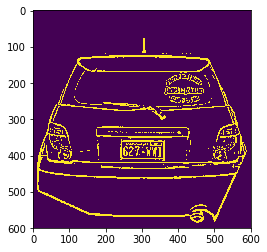

In [21]:
gray_image, binary_image = preprocess(image)
all_chars_in_scene = find_chars_in_scene(binary_image)

3. divide characters from the possible characters into groups

In [43]:
MAX_DIAG_SIZE_MULTIPLE_AWAY = 5.0
MIN_DIAG_SIZE_MULTIPLE_AWAY = 0.3
MAX_ANGLE_BETWEEN_CHARS = 12.0
MAX_CHANGE_IN_AREA = 0.5
MAX_CHANGE_IN_WIDTH = 0.8
MAX_CHANGE_IN_HEIGHT = 0.2

def angle_btw_chars(char_A, char_B):
    """
    return the angle between characters in degree
    """
    x_diff = np.abs(char_A.x - char_B.x)
    y_diff = np.abs(char_A.y - char_B.y)
    ## vertical to each other
    if x_diff == 0:
        angle = np.pi/2
    else:
        angle = np.arctan(y_diff / x_diff)
    return angle*(180/np.pi)

def check_char_dims(char_A, char_B):
    distance = np.sqrt((char_A.x - char_B.x)**2 + (char_A.y - char_B.y)**2)
    angle_diff = angle_btw_chars(char_A, char_B)
    area_diff_ratio = np.abs(char_A.area - char_B.area) / char_A.area
    width_diff_ratio = np.abs(char_A.width - char_B.width) / char_A.width
    height_diff_ratio = np.abs(char_A.height - char_B.height) / char_A.height
    
    if (distance < char_A.diag_size * MAX_DIAG_SIZE_MULTIPLE_AWAY and angle_diff < MAX_ANGLE_BETWEEN_CHARS and
            area_diff_ratio < MAX_CHANGE_IN_AREA and width_diff_ratio < MAX_CHANGE_IN_WIDTH and
            height_diff_ratio < MAX_CHANGE_IN_HEIGHT):
        return True
    else:
        return False

In [23]:
MIN_NUMBER_OF_MATCHING_CHARS = 3

def find_char_groups(all_chars_in_scene):
    """
    找到 list of matching chars, group 在一起变成新的 list, 删掉 原来list 中的这些 matching chars
    重复找 这种 group, 最后 return list of group
    ==== 问题: 没有找到 longest possible group, 可能会遗失一些有用的 group ====
    """
    all_groups = list()
    all_chars = np.copy(all_chars_in_scene)
    fail_time = 0
    while(len(all_chars) != 0):
        char_A = all_chars[0]
        group = [char_A]
        for i in range(1,len(all_chars)):
            char_B = all_chars[i]
            if check_char_dims(char_A, char_B):
                group.append(char_B)
        ## invalid group
        if len(group) < MIN_NUMBER_OF_MATCHING_CHARS:
            tmp = all_chars[1:]
            all_chars[-1] = char_A
            all_chars[:-1] = tmp
            fail_time += 1
            ## the rest chars will not form group
            if fail_time == len(all_chars):
                break
        else:
            fail_time = 0
            all_groups.append(group)
            all_chars = list(set(all_chars) - set(group))
    return all_groups

In [24]:
all_groups = find_char_groups(all_chars_in_scene)

In [30]:
for group in all_groups:
    for char in group:
        print(char.x, char.y, char.width, char.height)
    print('----')

249 374 12 28
264 375 13 28
281 375 13 28
311 375 13 28
328 376 12 28
344 376 9 28
----
425 179 10 16
472 178 9 16
493 177 7 13
----


4. find plates from character groups

In [33]:
class Plate(object):
    def __init__(self):
        self.plate_image = None
        self.gray_image = None
        self.binary_image = None
        ## rr_loc_plate: ((x,y), (width,height), angle)
        self.rr_loc_plate = None
        self.chars = ""

In [40]:
PLATE_WIDTH_PADDING_FACTOR = 1.3
PLATE_HEIGHT_PADDING_FACTOR = 1.5

def extract_all_plates(image, all_groups):
    """
    convert groups to one plate object; return list of possible plates
    """
    all_plates = list()
    for group in all_groups:  
        plate = Plate()
        ## sort chars from left to right based on x position
        group.sort(key = lambda a: a.x)
        center_x = (group[0].x + group[-1].x)/2
        center_y = (group[0].y + group[-1].y)/2
        ## allow a larger bounding box
        plate_width = int((group[-1].width + group[-1].x - group[0].x)*PLATE_WIDTH_PADDING_FACTOR )
        plate_height = int(np.mean(list(map(lambda a: a.height, group)))*PLATE_HEIGHT_PADDING_FACTOR )
        
        ## calculate correction angle between two plates
        height_diff = group[-1].y - group[0].y
        distance = np.sqrt((group[-1].x - group[0].x)**2 + (group[-1].y - group[0].y)**2 )
        angle = np.arcsin(height_diff / distance)
        angle = angle * (180 / np.pi)
        plate.rr_loc_plate = ( (center_x, center_y), (plate_width, plate_height), angle)
        ## rotate the plate using angle, affine transform
        rotation_mat = cv2.getRotationMatrix2D(plate.rr_loc_plate[0], angle, scale=1)
        height, width, _ = image.shape
        image_rotate = cv2.warpAffine(image, rotation_mat, (width, height))
        image_crop = cv2.getRectSubPix(image_rotate, plate.rr_loc_plate[1], plate.rr_loc_plate[0] )
        plate.plate_image = image_crop
        
        if plate.plate_image is not None:
            all_plates.append(plate)
        
    return all_plates

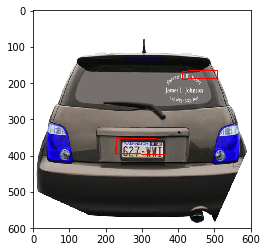

In [41]:
all_plates = extract_all_plates(image, all_groups)
if debug == True:
    tmp_image = np.copy(image)
    for i in range(len(all_plates)):
        box_points = cv2.boxPoints(all_plates[i].rr_loc_plate)
        ## draw bb
        cv2.line(tmp_image, tuple(box_points[0]), tuple(box_points[1]), (255,0,0), 2)
        cv2.line(tmp_image, tuple(box_points[1]), tuple(box_points[2]), (255,0,0), 2)
        cv2.line(tmp_image, tuple(box_points[2]), tuple(box_points[3]), (255,0,0), 2)
        cv2.line(tmp_image, tuple(box_points[3]), tuple(box_points[0]), (255,0,0), 2)
    plt.imshow(tmp_image)

5. find characters in the plate

In [42]:
def segment_chars(binary_image):
    image = np.copy(binary_image)
    cont_image, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    all_chars = list()
    for contour in contours:
        char = Character(contour)
        if check_char_dims(char):
            all_chars.append(char)
    return all_chars

In [44]:
def remove_overlapping_chars(group):
    """
    remove the smaller one of overlapping chars (compare area)
    """
    final_group = np.copy(group)
    for char_A in group:
        for char_B in group:
            if char_A == char_B: continue
            distance = np.sqrt((char_A.x - char_B.x)**2 + (char_A.y - char_B.y)**2)
            ## overlapping chars
            if distance < char_A.diag_size * MIN_DIAG_SIZE_MULTIPLE_AWAY:
                if char_A.area > char_B.area and char_B in final_group:
                    final_group.remove(char_B)
                if char_B.area > char_A.area and char_A in final_group:
                    final_group.remove(char_A)
    return final_group

In [48]:
RESIZED_CHAR_IMAGE_WIDTH = 20
RESIZED_CHAR_IMAGE_HEIGHT = 30
def recognize_chars_in_plate(binary_image, all_groups):
    """
    Assume the longest group is the correct group in the plate
    """
    all_groups.sort(lambda a : len(a))
    group = np.copy(all_groups[-1])
    group.sort(lambda a: a.x)
    image_thresh_color = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), np.uint8)
    cv2.cvtColor(binary_image, cv2.COLOR_GRAY2BGR, image_thresh_color)
    number = ""
    for char in group:
        ## top left corner
        pt1 = (char.x, char.y)
        ## bottom right corner
        pt2 = (char.x + char.width, char.y + char.height)
        ## draw rectangle around char
        cv2.rectangle(image_thresh_color, pt1, pt2, (0,255,0), 2)
        ## crop char outof plate
        image_ROI = binary_image[pt1[1]:pt2[1], pt1[0]:pt2[0]]
        image_ROI = cv2.resize(image_ROI, (RESIZED_CHAR_IMAGE_WIDTH, RESIZED_CHAR_IMAGE_HEIGHT) )
        """
        the rest is recognition of character
        """
        char = model.predict(image_ROI)
        number += char
        
    if debug == True:
        plt.figure()
        plt.imshow(image_thresh_color)
    return number

In [50]:
def find_char_groups_in_plates(all_plates):
    for plate_idx in range(len(all_plates)):
        plate = all_plates[plate_idx]
        plate.gray_image, plate.binary_image = preprocess(plate.plate_image)
        ## increase size for better detection
        plate.binary_image = cv2.resize(plate.binary_image, (0, 0), fx = 1.6, fy = 1.6)
        threshold, plate.binary_image = cv2.threshold(plate.binary_image, 0.0, 255.0, 
                                                                cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        ## segment characters in the plate
        all_chars = segment_chars(plate.binary_image)
        ## show contours
        if debug == True:
            width, height = plate.rr_loc_plate[1]
            tmp = np.zeros((height, width, 3), np.uint8)
            all_contours = list()
            for char in all_chars:
                all_contours.append(char.contour)
            cv2.drawContours(tmp, contours, -1, (255, 255, 255))
            plt.figure()
            plt.imshow(tmp)
        
        ## find groups of chars in plate ?????
        all_groups = find_char_groups(all_chars)
        if len(all_groups) == 0: continue
        else:
            ## remove overlapping characters
            for group_idx in range(len(all_groups)):
                group = all_groups[group_idx]
                group.sort(lambda a: a.x)
                group = remove_overlapping_chars(group)
                all_groups[group_idx] = group
            ## recognize the numbers in the plate
            number = recognize_chars_in_plate(plate.binary_image, all_groups)
            plate.chars = number
            all_plates[plate_idx] = plate
    return all_plates

In [ ]:
all_plates = find_char_groups_in_plates(all_plates)
for plate in all_plates:
    print('recognized number: ', plate.chars)